In [1]:
import torch 
from torch import nn
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Cuda Device Available")
    print("Name of the Cuda Device: ", torch.cuda.get_device_name())
    print("GPU Computational Capablity: ", torch.cuda.get_device_capability())

else:
    device = torch.device("cpu")

#Rough Estimate made Graphically
def MultiplyPE(pe):
    pe = pe * 25
    return pe

#Scales PE for 2012 y intercept
def ScalePERatio(df):
    df['Shiller PE Ratio'] = df['Shiller PE Ratio'].apply(MultiplyPE)
    return df

    
def BuildSandPDataSet():
    df = pd.read_csv("SandP500Data.csv", sep = ',')
    #df.drop('Volume', inplace = True, axis=1)
    df = df.sort_index(axis=0,ascending=False).reset_index()
    df.drop('index', inplace = True, axis = 1)
    return df

def BuildShillerPeDataSet():
    df = pd.read_csv("ShillerPERatio.csv", sep = ',', skiprows = [0])
    df = df.rename(columns={'DateTime': 'Date'})
    #df['Date'] = df['Date'].apply(ChangeDateShiller)
    df = df.sort_index(axis=0,ascending=False).reset_index()
    df.drop('index', inplace = True, axis = 1)
    return df

def BuildDataset():
    SP = BuildSandPDataSet()
    PE = BuildShillerPeDataSet()
    df = pd.merge(SP, PE, how="inner", on=["Date"])
    df = df[['Date', 'Open', 'High', 'Low', 'Volume', 'Shiller PE Ratio', 'Close']]
    return df

def MergeByDate(df1, df2):
    dfinal = df1.merge(df2, on="Date", how = 'inner')
    return dfinal


#Looks like the derivatives of each are correlated
#Even though maybe the magnitudes are not
def GraphPEToClose(SandPData, PEData, logy = True):
    if logy == False:
        #PEData = ScalePERatio(PEData)
        title = "Graph of S&P and Schiller PE"
    else:
         title = "Graph of S&P and Schiller PE"
       
    dfinal = MergeByDate(SandPData, PEData)
    dfinal[:].plot(x='Date', y=['Close', 'Shiller PE Ratio'], figsize=(10,5), logy = logy, title = title, grid=True)

def PEGraph():
    SP = BuildSandPDataSet()
    PE = BuildShillerPeDataSet()
    GraphPEToClose(SP, PE)
    
def BuildInputSequence(dataset, window, prediction):
    
    features = []
    labels = []

    for i in range(0, len(dataset) - window + 1 - prediction):
        feature = []
        label = []
        for j in range(0, window):
            row = []
            row.append(np.log(dataset['Open'][i + j]))
            row.append(np.log(dataset['High'][i + j]))
            row.append(np.log(dataset['Low'][i + j]))
            row.append(np.log(dataset['Volume'][i + j]))
            row.append(np.log(dataset['Shiller PE Ratio'][i + j]))
            row.append(np.log(dataset['Close'][i + j]))
            feature.append(row)

        for j in range(0, prediction):
            label.append(np.log(dataset['Open'][i + window + j]))
            label.append(np.log(dataset['High'][i + window + j]))
            label.append(np.log(dataset['Low'][i + window + j]))
            label.append(np.log(dataset['Volume'][i + window + j]))
            label.append(np.log(dataset['Shiller PE Ratio'][i + window + j]))
            label.append(np.log(dataset['Close'])[i + window + j])

        features.append(feature)
        labels.append(label)
        
    return [features, labels]

def TrainTestDataset(window = 1, prediction = 1):
    df = BuildDataset()
    a = BuildInputSequence(df, window, prediction)
   
    X_train, X_test, Y_train, Y_test = train_test_split(a[0], a[1], test_size = 0.2)
    
    return [X_train, Y_train, X_test, Y_test]


class RNN(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_size, layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        self.rnn = nn.RNN(input_size, hidden_size, layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.layers, batch_size, self.hidden_size).to(device)
        return hidden
    
def Train(Model, X_train, Y_train, epochs, batchSize, learningRate):
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Model.parameters(), lr=learningRate)
    
    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    dataLoader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batchSize, shuffle=True)
    
    for epoch in range(epochs):
        for i, (data, label) in enumerate(dataLoader):
            data = data.to(device)
            label = label.type(torch.float32)
            label = label.to(device)

            output, hidden = Model(data)
            #output = output.squeeze(1)
            output = output.float()
            label = label.float()
            #print(str(data), "\n")
            #print(str(output), "\n")
            #print(str(label), "\n")
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #if(loss.item() < 0.01):
                #print("Done Training..")
                #return
        if epoch % 10 == 0:
            print("Epoch: " + str(epoch) + " Loss: " + str(loss.item()))
    
#rnn = RNN(6, 32, 1)
D = TrainTestDataset(1)
X_train, Y_train, X_test, Y_test = D[0], D[1], D[2], D[3]


X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

X_train.shape


Model = RNN(6, 6, 32, 1)
Model = Model.to(device)

Train(Model, X_train, Y_train, 200, 10, 0.01)



#Getting Input size[30]
#Expecting Output size [10, 1]

#Getting Input size[12]
#Expecting Output size [4, 1]


Epoch: 0 Loss: 23.24887466430664
Epoch: 10 Loss: 0.5583272576332092
Epoch: 20 Loss: 0.7333729267120361
Epoch: 30 Loss: 0.5542628169059753
Epoch: 40 Loss: 0.40069642663002014
Epoch: 50 Loss: 0.18363380432128906
Epoch: 60 Loss: 0.07470635324716568
Epoch: 70 Loss: 0.11885906755924225
Epoch: 80 Loss: 0.07048667967319489
Epoch: 90 Loss: 0.034170232713222504
Epoch: 100 Loss: 0.04734541475772858
Epoch: 110 Loss: 0.025100525468587875
Epoch: 120 Loss: 0.06269052624702454
Epoch: 130 Loss: 0.045929864048957825
Epoch: 140 Loss: 0.05935988202691078
Epoch: 150 Loss: 0.020313212648034096
Epoch: 160 Loss: 0.029908491298556328
Epoch: 170 Loss: 0.017036063596606255
Epoch: 180 Loss: 0.02743479423224926
Epoch: 190 Loss: 0.032011039555072784


In [2]:
def PredictAhead(M, XInit, FarAhead):
    output = XInit
    for _ in range(FarAhead):
        output, hidden = M(output)
        output = torch.Tensor([output.cpu().detach().numpy()]).to(device)
        #print(output)
    output = output.cpu().detach().numpy()
    return math.e**output[-1][-1][-1]

#print(Model(X_train[0:1].to(device))[0])
print(X_train[0:10])
#print(Model(X_train[0:10].to(device))[0])
#print(type(X_train[0:1].to(device)))
PredictAhead(Model, X_train[0:5].to(device), 7)


tensor([[[ 6.8152,  6.8721,  6.7256, 24.1008,  3.1608,  6.8201]],

        [[ 7.0310,  7.1645,  6.9799, 25.3089,  3.0037,  7.1335]],

        [[ 6.1171,  6.1371,  6.0933, 22.5720,  2.9912,  6.1296]],

        [[ 7.4000,  7.4558,  7.3984, 24.9156,  3.1544,  7.4275]],

        [[ 7.1370,  7.1722,  7.1370, 25.2468,  3.1346,  7.1594]],

        [[ 7.6198,  7.6198,  7.5023, 25.2495,  3.1868,  7.5706]],

        [[ 7.2829,  7.3158,  7.2230, 25.2383,  3.2638,  7.2957]],

        [[ 6.9384,  7.0219,  6.9186, 25.2748,  2.9791,  7.0045]],

        [[ 5.9606,  5.9759,  5.9299, 22.1299,  2.9096,  5.9724]],

        [[ 7.1919,  7.1946,  7.1301, 25.2176,  3.1311,  7.1898]]])


/var/folders/lm/hx9psr516vj_d0psqp_60nc40000gn/T/ipykernel_33267/782134499.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  output = torch.Tensor([output.cpu().detach().numpy()]).to(device)


3734.0414675761294

In [39]:
def Test(M):
    e = math.e
    
    data = BuildDataset().to_dict('split')['data']
    data_dict = {}
    
    
    dates = []
    for i in range(len(data)):
        data_dict[data[i][0]] = data[i][5]
        dates.append(data[i][0])
        
    
    #for one day prediction on train data
    trainOne = []
    
    for i in range(len(X_train) - 7):
        pred = PredictAhead(Model, X_train[i:i + 5].to(device), 1)
        trainOne.append((pred - e**X_train[i + 6][-1][-1]) / e**X_train[i + 6][-1][-1])
        
    
    plt.plot(dates[:len(trainOne)], trainOne)
    plt.show()
        
    #for one day prediction on test data
    testOne = []
    
    for i in range(len(X_test) - 7):
        pred = PredictAhead(Model, X_test[i:i + 5].to(device), 1)
        testOne.append((pred - e**X_test[i + 6][-1][-1]) / e**X_test[i + 6][-1][-1])
        
    plt.plot(dates[:len(testOne)], testOne)
    plt.show()
    
    #for two day prediction on train data
    trainTwo = []
    
    for i in range(len(X_train) - 8):
        pred = PredictAhead(Model, X_train[i:i + 5].to(device), 2)
        trainTwo.append((pred - e**X_train[i + 7][-1][-1]) / e**X_train[i + 7][-1][-1])    
    
    plt.plot(dates[:len(trainTwo)], trainTwo)
    plt.show()
    
    #for two day prediction on test data
    testTwo = []
    
    for i in range(len(X_test) - 8):
        pred = PredictAhead(Model, X_test[i:i + 5].to(device), 2)
        testTwo.append((pred - e**X_test[i + 7][-1][-1]) / e**X_test[i + 7][-1][-1])
        
    plt.plot(dates[:len(testTwo)], testTwo)
    plt.show()
    
    #for three day prediction on train data
    trainThree = []
    
    for i in range(len(X_train) - 9):
        pred = PredictAhead(Model, X_train[i:i + 5].to(device), 3)
        trainThree.append((pred - e**X_train[i + 8][-1][-1]) / e**X_train[i + 8][-1][-1])
    
    
    plt.plot(dates[:len(trainThree)], trainThree)
    plt.show()
    
    #for three day prediction on test data
    testThree = []
    
    for i in range(len(X_test) - 9):
        pred = PredictAhead(Model, X_test[i:i + 5].to(device), 3)
        testThree.append((pred - e**X_test[i + 8][-1][-1]) / e**X_test[i + 8][-1][-1])
    
    plt.plot(dates[:len(trainThree)], trainThree)
    plt.show()
    
    #for four day prediction on train data
    trainFour = []
    
    for i in range(len(X_train) - 10):
        pred = PredictAhead(Model, X_train[i:i + 5].to(device), 4)
        trainFour.append((pred - e**X_train[i + 9][-1][-1]) / e**X_train[i + 9][-1][-1])
    
    plt.plot(dates[:len(trainFour)], trainFour)
    plt.show()
    
    #for four day prediction on test data
    testFour = []
    
    for i in range(len(X_test) - 10):
        pred = PredictAhead(Model, X_test[i:i + 5].to(device), 4)
        testFour.append((pred - e**X_test[i + 9][-1][-1]) / e**X_test[i + 9][-1][-1])
        
    plt.plot(dates[:len(testFour)], testFour)
    plt.show()
        

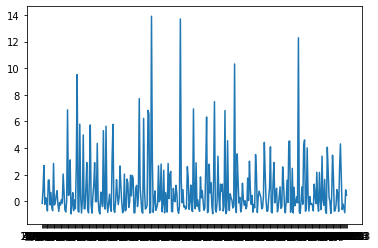

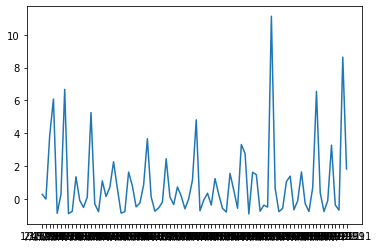

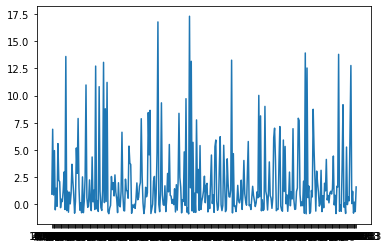

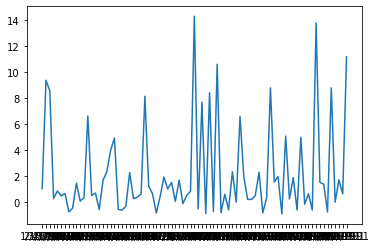

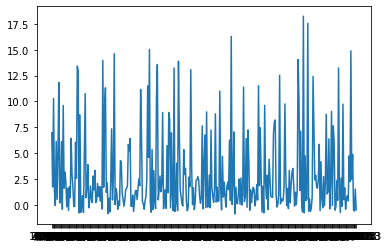

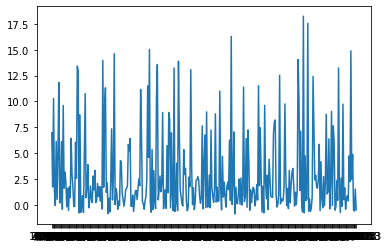

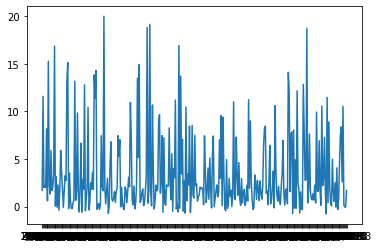

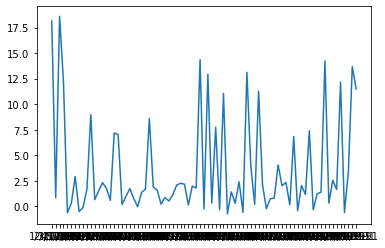

In [40]:
Test(Model)